# 🫀 Heart Disease Prediction - EDA & Preprocessing

Phân tích khám phá dữ liệu (EDA) và tiền xử lý dữ liệu bệnh tim sử dụng PySpark.

## 📦 1. Import Libraries & Initialize Spark

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Setup PySpark
if 'SPARK_HOME' in os.environ:
    del os.environ['SPARK_HOME']
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, mean, stddev, sqrt, lit, round as spark_round
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Initialize Spark
spark = SparkSession.builder.appName('HeartDiseaseEDA').getOrCreate()
print('✅ Spark Session Created Successfully!')
spark

✅ Spark Session Created Successfully!


## 📂 2. Load Data

In [2]:
# Load dataset
df = spark.read.csv('../data/raw/cardio_train.csv', header=True, sep=',', inferSchema=True)
print(f'📊 Dataset Shape: {df.count()} rows x {len(df.columns)} columns')
df.show(10)

📊 Dataset Shape: 70000 rows x 13 columns
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 

## 📋 3. Data Overview

In [3]:
# Schema
print('🔍 Data Schema:')
df.printSchema()

🔍 Data Schema:
root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [5]:
# Feature descriptions
feature_info = {
    'id': 'Unique identifier',
    'age': 'Age in days',
    'gender': 'Gender (1: Female, 2: Male)',
    'height': 'Height in cm',
    'weight': 'Weight in kg',
    'ap_hi': 'Systolic blood pressure',
    'ap_lo': 'Diastolic blood pressure',
    'cholesterol': 'Cholesterol (1: Normal, 2: Above Normal, 3: High)',
    'gluc': 'Glucose (1: Normal, 2: Above Normal, 3: High)',
    'smoke': 'Smoking (0: No, 1: Yes)',
    'alco': 'Alcohol intake (0: No, 1: Yes)',
    'active': 'Physical activity (0: No, 1: Yes)',
    'cardio': 'Target: Heart disease (0: No, 1: Yes)'
}
print('📝 Feature Descriptions:')
for feat, desc in feature_info.items():
    print(f'  • {feat}: {desc}')

📝 Feature Descriptions:
  • id: Unique identifier
  • age: Age in days
  • gender: Gender (1: Female, 2: Male)
  • height: Height in cm
  • weight: Weight in kg
  • ap_hi: Systolic blood pressure
  • ap_lo: Diastolic blood pressure
  • cholesterol: Cholesterol (1: Normal, 2: Above Normal, 3: High)
  • gluc: Glucose (1: Normal, 2: Above Normal, 3: High)
  • smoke: Smoking (0: No, 1: Yes)
  • alco: Alcohol intake (0: No, 1: Yes)
  • active: Physical activity (0: No, 1: Yes)
  • cardio: Target: Heart disease (0: No, 1: Yes)


In [6]:
from pyspark.sql import functions as F

# Summary statistics - Display as formatted table with 12 parameters
print('📈 Summary Statistics (12 Parameters):')

# Get numeric columns (exclude 'id')
numeric_cols = [field.name for field in df.schema.fields if field.name != 'id']

# Get total count
total_count = df.count()

# Calculate all statistics
stats_list = []

for col_name in numeric_cols:
    # Count non-null values
    col_count = df.filter(F.col(col_name).isNotNull()).count()

    # Basic stats
    basic_stats = df.select(
        F.min(col_name).alias('Min'),
        F.max(col_name).alias('Max'),
        F.mean(col_name).alias('Mean'),
        F.stddev(col_name).alias('Std'),
        F.variance(col_name).alias('Var')
    ).collect()[0]

    # Percentiles: Q1 (25%), Q2/Median (50%), Q3 (75%)
    percentiles = df.approxQuantile(col_name, [0.25, 0.5, 0.75], 0.01)
    Q1, Q2, Q3 = percentiles[0], percentiles[1], percentiles[2]
    IQR = Q3 - Q1

    # Mode (most frequent value)
    mode_row = df.groupBy(col_name).count().orderBy(F.desc('count')).first()
    mode_val = mode_row[0] if mode_row else None

    stats_list.append({
        'Column': col_name,
        'Count': col_count,
        'Min': round(float(basic_stats['Min']), 2) if basic_stats['Min'] is not None else None,
        'Max': round(float(basic_stats['Max']), 2) if basic_stats['Max'] is not None else None,
        'Mode': round(float(mode_val), 2) if mode_val is not None else None,
        'Mean': round(float(basic_stats['Mean']), 2) if basic_stats['Mean'] is not None else None,
        'Median': round(Q2, 2),
        'Q1': round(Q1, 2),
        'Q2': round(Q2, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Std': round(float(basic_stats['Std']), 2) if basic_stats['Std'] is not None else None,
        'Var': round(float(basic_stats['Var']), 2) if basic_stats['Var'] is not None else None
    })

# Convert to Pandas DataFrame for display
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df.set_index('Column')

# Reorder columns for better readability
column_order = ['Count', 'Min', 'Max', 'Mode', 'Mean', 'Median', 'Q1', 'Q2', 'Q3', 'IQR', 'Std', 'Var']
stats_df = stats_df[column_order]

# Display the formatted table
display(stats_df)

📈 Summary Statistics (12 Parameters):


,Count,Min,Max,Mode,Mean,Median,Q1,Q2,Q3,IQR,Std,Var
Column,,,,,,,,,,,,
age,70000,10798.0,23713.0,19741.0,19468.87,19699.0,17578.0,19699.0,21316.0,3738.0,2467.25,6087330.79
gender,70000,1.0,2.0,1.0,1.35,1.0,1.0,1.0,2.0,1.0,0.48,0.23
height,70000,55.0,250.0,165.0,164.36,165.0,159.0,165.0,170.0,11.0,8.21,67.41
weight,70000,10.0,200.0,65.0,74.21,72.0,65.0,72.0,82.0,17.0,14.40,207.24
ap_hi,70000,-150.0,16020.0,120.0,128.82,120.0,120.0,120.0,140.0,20.0,154.01,23719.52
ap_lo,70000,-70.0,11000.0,80.0,96.63,80.0,80.0,80.0,90.0,10.0,188.47,35521.89
cholesterol,70000,1.0,3.0,1.0,1.37,1.0,1.0,1.0,1.0,0.0,0.68,0.46
gluc,70000,1.0,3.0,1.0,1.23,1.0,1.0,1.0,1.0,0.0,0.57,0.33
smoke,70000,0.0,1.0,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.28,0.08


## 🔍 4. Missing Values & Duplicates Check

In [7]:
# Check null values
print('❓ Missing Values Check:')
missing_df = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing_df.show()

❓ Missing Values Check:
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|  0|     0|     0|     0|    0|    0|          0|   0|    0|   0|     0|     0|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+



In [8]:
# Check duplicates
total_rows = df.count()
unique_rows = df.dropDuplicates().count()
duplicates = total_rows - unique_rows
print(f'📊 Total rows: {total_rows}')
print(f'📊 Unique rows: {unique_rows}')
print(f'🔄 Duplicate rows: {duplicates}')

# Drop duplicates
df = df.dropDuplicates()
print(f'✅ After dropping duplicates: {df.count()} rows')

📊 Total rows: 70000
📊 Unique rows: 70000
🔄 Duplicate rows: 0
✅ After dropping duplicates: 70000 rows


## 🎯 5. Target Variable Analysis

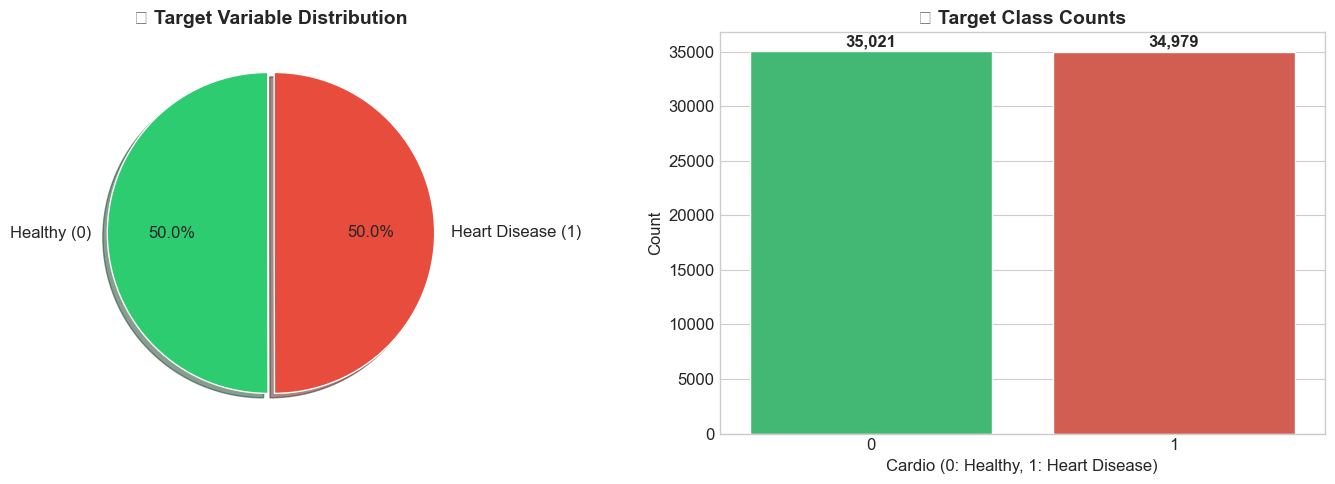

✅ Chart saved to ../results/01_target_distribution.png


In [9]:
# Convert to pandas for visualization
pdf = df.toPandas()

# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
target_counts = pdf['cardio'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(target_counts, labels=['Healthy (0)', 'Heart Disease (1)'], autopct='%1.1f%%',
            colors=colors, explode=(0.02, 0.02), shadow=True, startangle=90)
axes[0].set_title('🎯 Target Variable Distribution', fontsize=14, fontweight='bold')

# Bar chart
sns.countplot(x='cardio', data=pdf, ax=axes[1], palette=colors)
axes[1].set_xlabel('Cardio (0: Healthy, 1: Heart Disease)')
axes[1].set_ylabel('Count')
axes[1].set_title('📊 Target Class Counts', fontsize=14, fontweight='bold')
for i, v in enumerate(target_counts.sort_index()):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/01_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Chart saved to ../results/01_target_distribution.png')

## 📊 6. Numeric Features Distribution

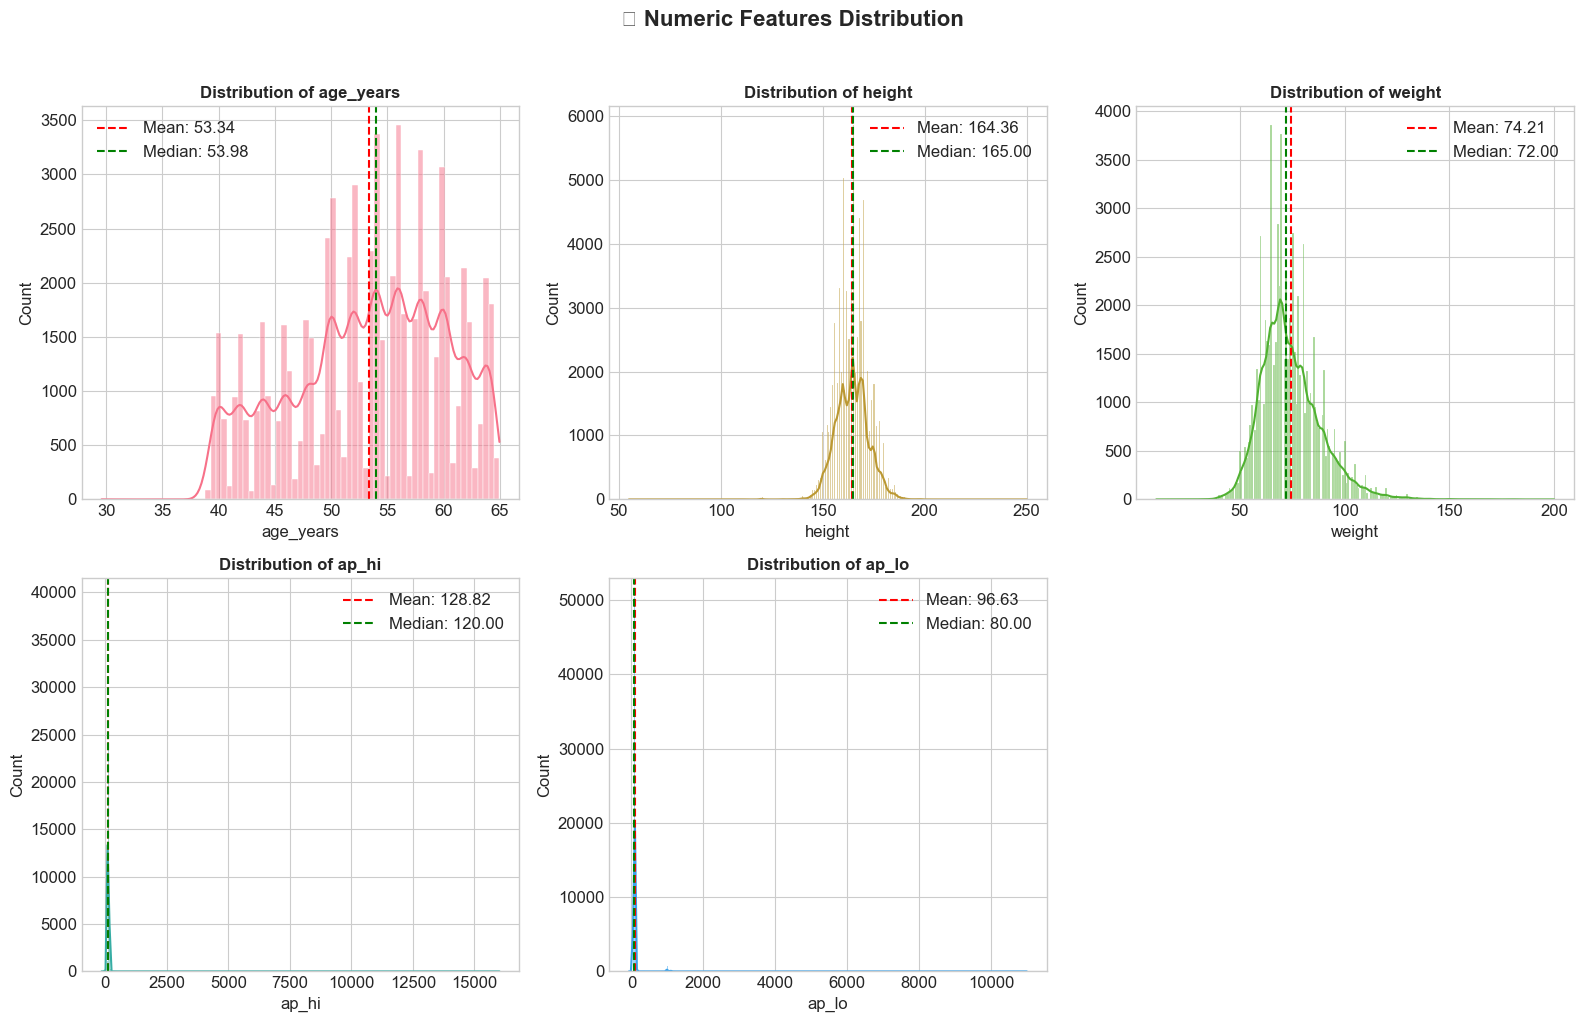

✅ Chart saved to ../results/02_numeric_distributions.png


In [10]:
# Convert age to years
pdf['age_years'] = pdf['age'] / 365

# Numeric features histograms
numeric_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(numeric_cols):
    sns.histplot(pdf[col_name], kde=True, ax=axes[idx], color=sns.color_palette('husl')[idx])
    axes[idx].set_title(f'Distribution of {col_name}', fontsize=12, fontweight='bold')
    axes[idx].axvline(pdf[col_name].mean(), color='red', linestyle='--', label=f'Mean: {pdf[col_name].mean():.2f}')
    axes[idx].axvline(pdf[col_name].median(), color='green', linestyle='--', label=f'Median: {pdf[col_name].median():.2f}')
    axes[idx].legend()

axes[5].axis('off')
plt.suptitle('📊 Numeric Features Distribution', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/02_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/02_numeric_distributions.png')

## 📈 7. Categorical Features Analysis

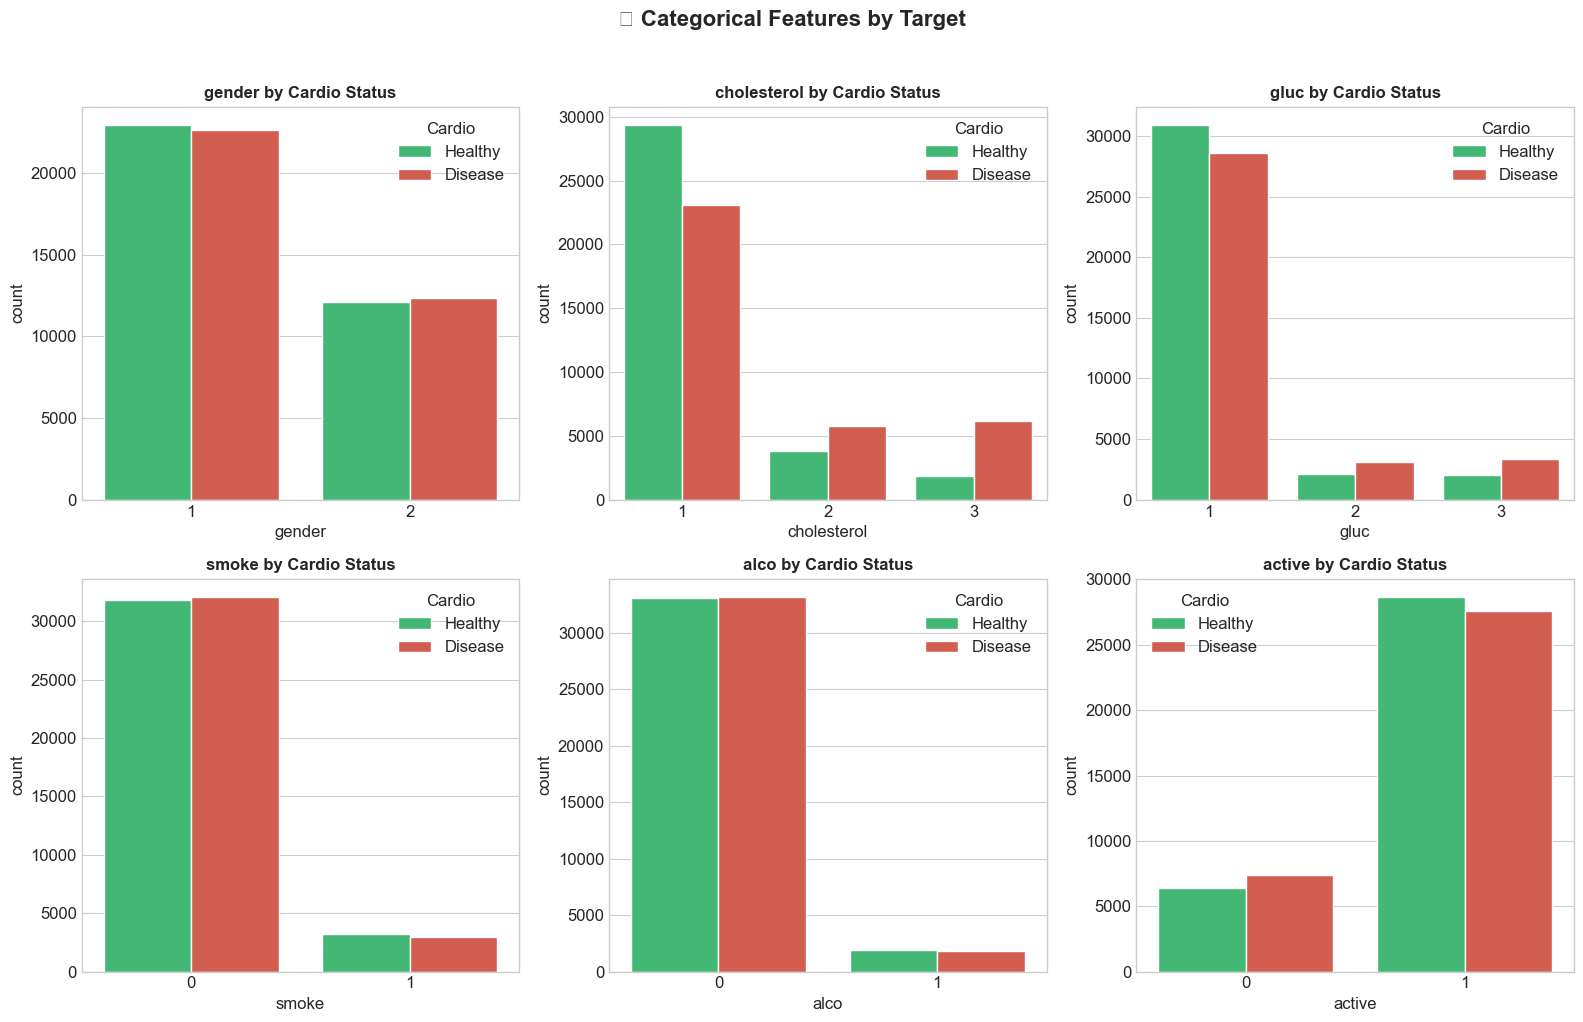

✅ Chart saved to ../results/03_categorical_by_target.png


In [11]:
# Categorical features
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(cat_cols):
    sns.countplot(x=col_name, hue='cardio', data=pdf, ax=axes[idx], palette=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{col_name} by Cardio Status', fontsize=12, fontweight='bold')
    axes[idx].legend(title='Cardio', labels=['Healthy', 'Disease'])

plt.suptitle('📈 Categorical Features by Target', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/03_categorical_by_target.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/03_categorical_by_target.png')

## 🔥 8. Correlation Analysis

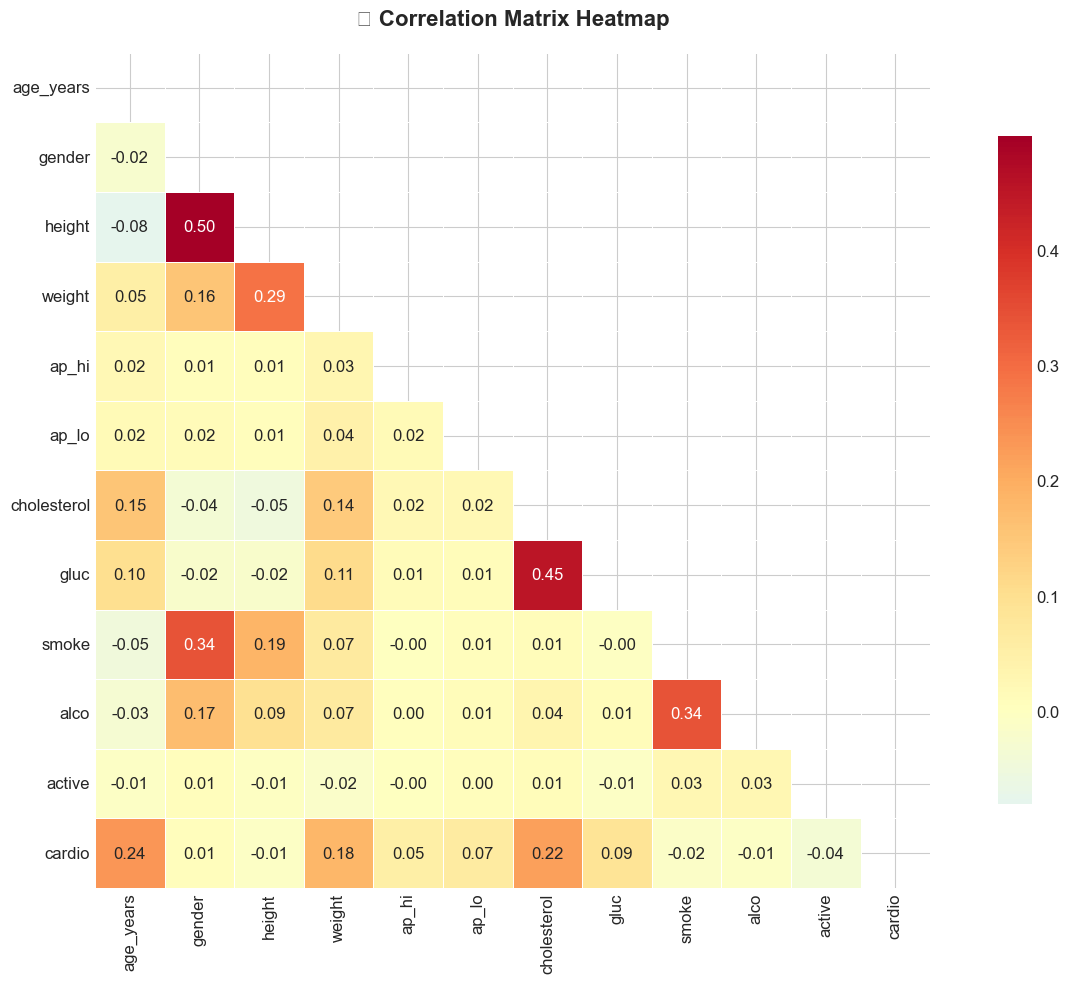

✅ Chart saved to ../results/04_correlation_matrix.png


In [12]:
# Correlation matrix
analysis_cols = ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
corr_matrix = pdf[analysis_cols].corr()

fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('🔥 Correlation Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/04_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/04_correlation_matrix.png')

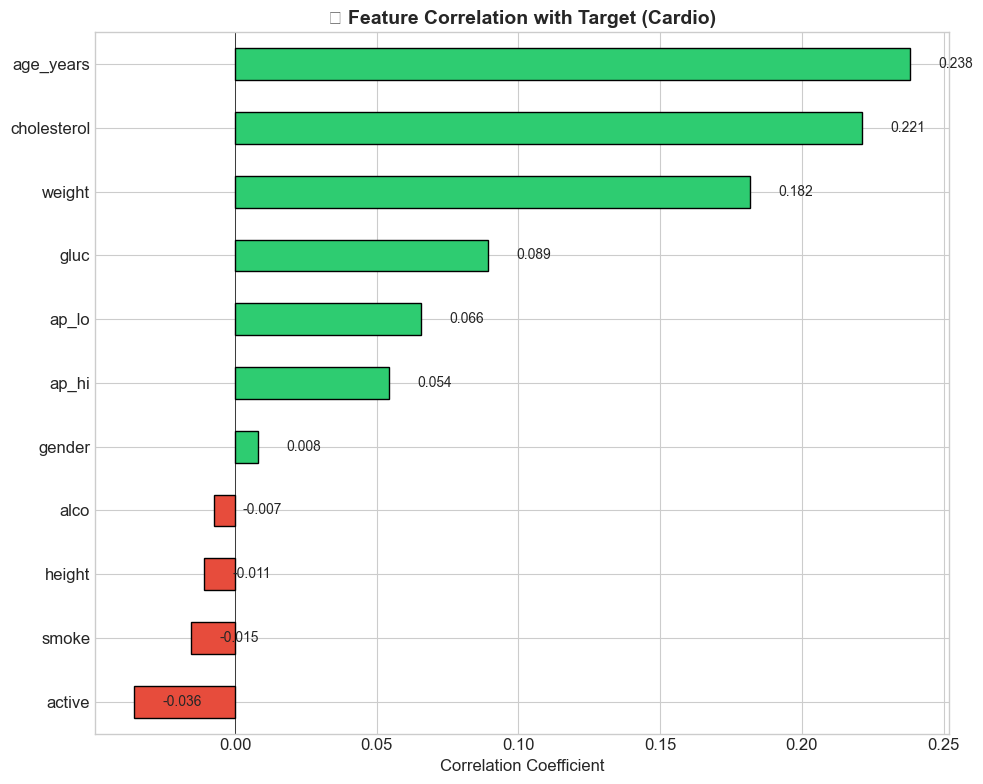

✅ Chart saved to ../results/05_target_correlation.png


In [13]:
# Feature correlation with target
target_corr = corr_matrix['cardio'].drop('cardio').sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in target_corr]
target_corr.plot(kind='barh', color=colors, ax=ax, edgecolor='black')
ax.set_xlabel('Correlation Coefficient')
ax.set_title('🎯 Feature Correlation with Target (Cardio)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
for i, v in enumerate(target_corr):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('../results/05_target_correlation.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/05_target_correlation.png')

## 📦 9. Outlier Detection with Box Plots

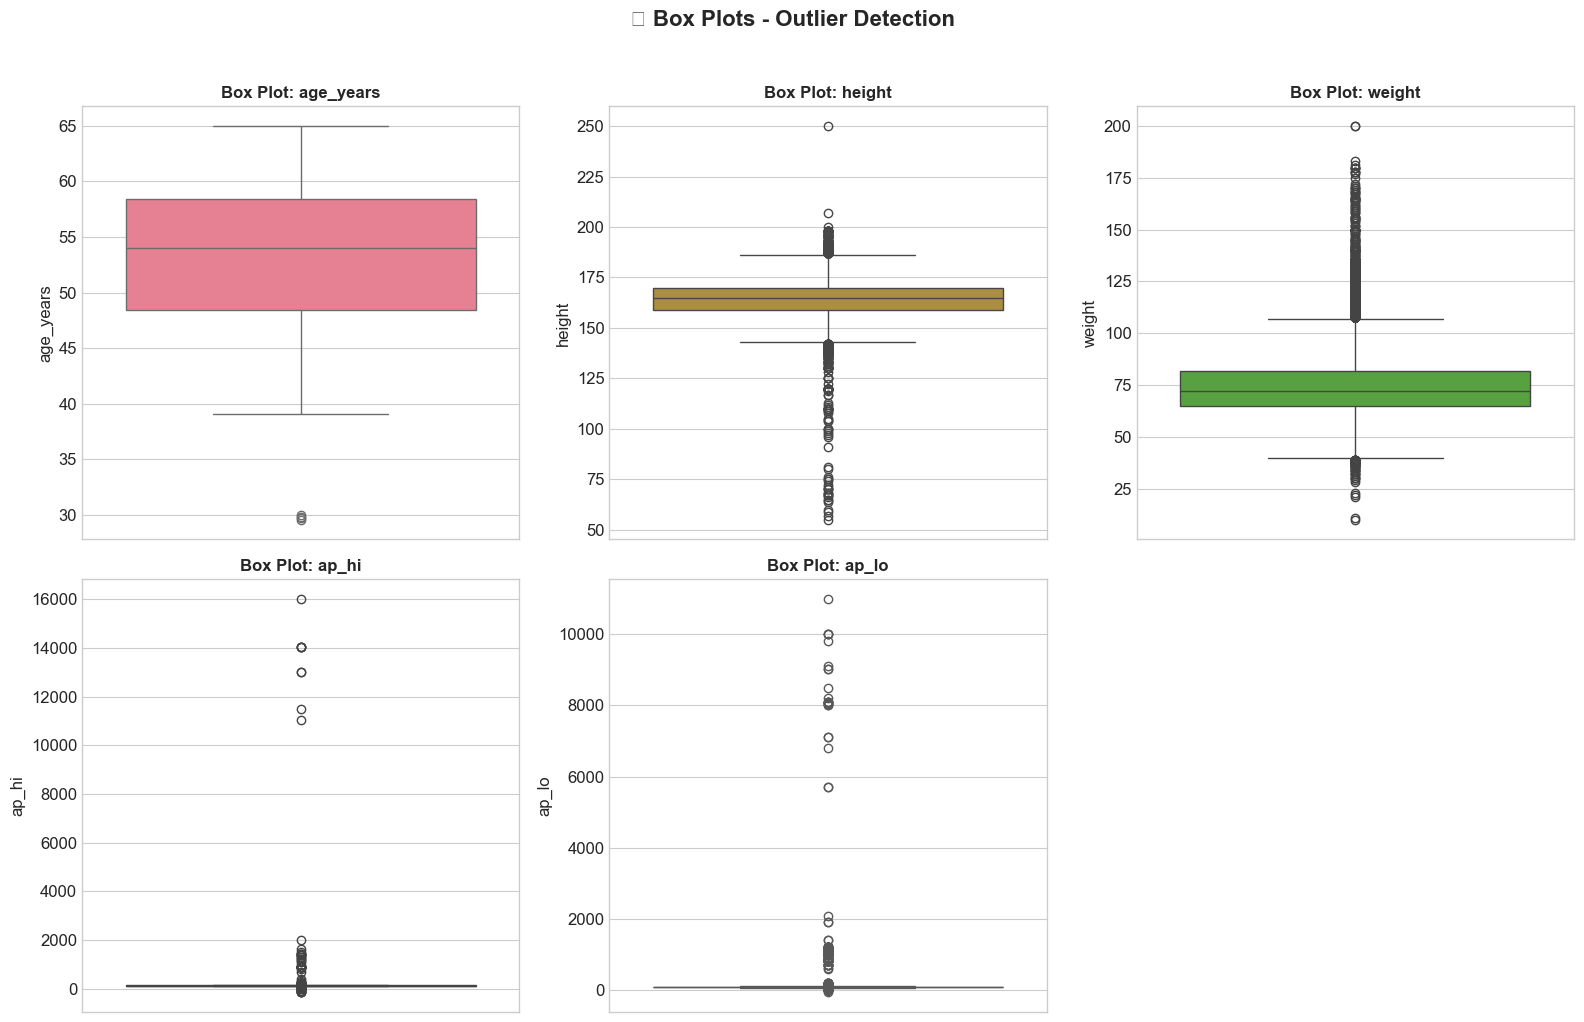

✅ Chart saved to ../results/06_boxplots_before.png


In [14]:
# Box plots for numeric features
numeric_for_outliers = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(numeric_for_outliers):
    sns.boxplot(y=pdf[col_name], ax=axes[idx], color=sns.color_palette('husl')[idx])
    axes[idx].set_title(f'Box Plot: {col_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col_name)

axes[5].axis('off')
plt.suptitle('📦 Box Plots - Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/06_boxplots_before.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/06_boxplots_before.png')

In [15]:
# Calculate outliers using IQR method
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers, lower, upper, Q1, Q3

print('📊 Outlier Analysis (IQR Method):')
print('=' * 70)
outlier_summary = []
for col_name in numeric_for_outliers:
    outliers, lower, upper, q1, q3 = count_outliers(pdf[col_name])
    pct = (outliers / len(pdf)) * 100
    outlier_summary.append({'Feature': col_name, 'Outliers': outliers, 'Percentage': f'{pct:.2f}%', 'Lower': f'{lower:.2f}', 'Upper': f'{upper:.2f}'})
    print(f'{col_name}: {outliers:,} outliers ({pct:.2f}%) | Range: [{lower:.2f}, {upper:.2f}]')

outlier_df = pd.DataFrame(outlier_summary)
print('\n📋 Summary Table:')
print(outlier_df.to_string(index=False))

📊 Outlier Analysis (IQR Method):
age_years: 4 outliers (0.01%) | Range: [33.34, 73.48]
height: 519 outliers (0.74%) | Range: [142.50, 186.50]
weight: 1,819 outliers (2.60%) | Range: [39.50, 107.50]
ap_hi: 1,435 outliers (2.05%) | Range: [90.00, 170.00]
ap_lo: 4,632 outliers (6.62%) | Range: [65.00, 105.00]

📋 Summary Table:
  Feature  Outliers Percentage  Lower  Upper
age_years         4      0.01%  33.34  73.48
   height       519      0.74% 142.50 186.50
   weight      1819      2.60%  39.50 107.50
    ap_hi      1435      2.05%  90.00 170.00
    ap_lo      4632      6.62%  65.00 105.00


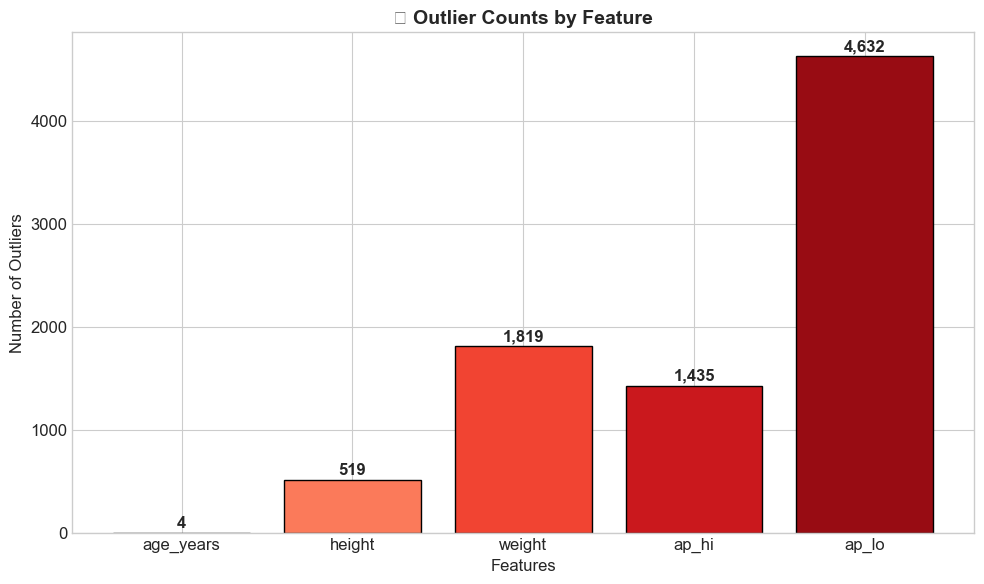

✅ Chart saved to ../results/07_outlier_counts.png


In [16]:
# Visualize outlier counts
fig, ax = plt.subplots(figsize=(10, 6))
outlier_counts = [count_outliers(pdf[col])[0] for col in numeric_for_outliers]
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(numeric_for_outliers)))
bars = ax.bar(numeric_for_outliers, outlier_counts, color=colors, edgecolor='black')
ax.set_xlabel('Features')
ax.set_ylabel('Number of Outliers')
ax.set_title('📊 Outlier Counts by Feature', fontsize=14, fontweight='bold')
for bar, count in zip(bars, outlier_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{count:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../results/07_outlier_counts.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/07_outlier_counts.png')

## 🔧 10. Outlier Treatment (IQR Capping)

In [17]:
# Create a copy for processing
pdf_clean = pdf.copy()

# Apply IQR capping
print('🔧 Applying IQR Capping...')
for col_name in numeric_for_outliers:
    Q1 = pdf_clean[col_name].quantile(0.25)
    Q3 = pdf_clean[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = len(pdf_clean[(pdf_clean[col_name] < lower) | (pdf_clean[col_name] > upper)])
    pdf_clean[col_name] = pdf_clean[col_name].clip(lower, upper)
    after = len(pdf_clean[(pdf_clean[col_name] < lower) | (pdf_clean[col_name] > upper)])
    print(f'  ✅ {col_name}: {before} outliers capped')

print('\n✅ Outlier treatment completed!')

🔧 Applying IQR Capping...
  ✅ age_years: 4 outliers capped
  ✅ height: 519 outliers capped
  ✅ weight: 1819 outliers capped
  ✅ ap_hi: 1435 outliers capped
  ✅ ap_lo: 4632 outliers capped

✅ Outlier treatment completed!


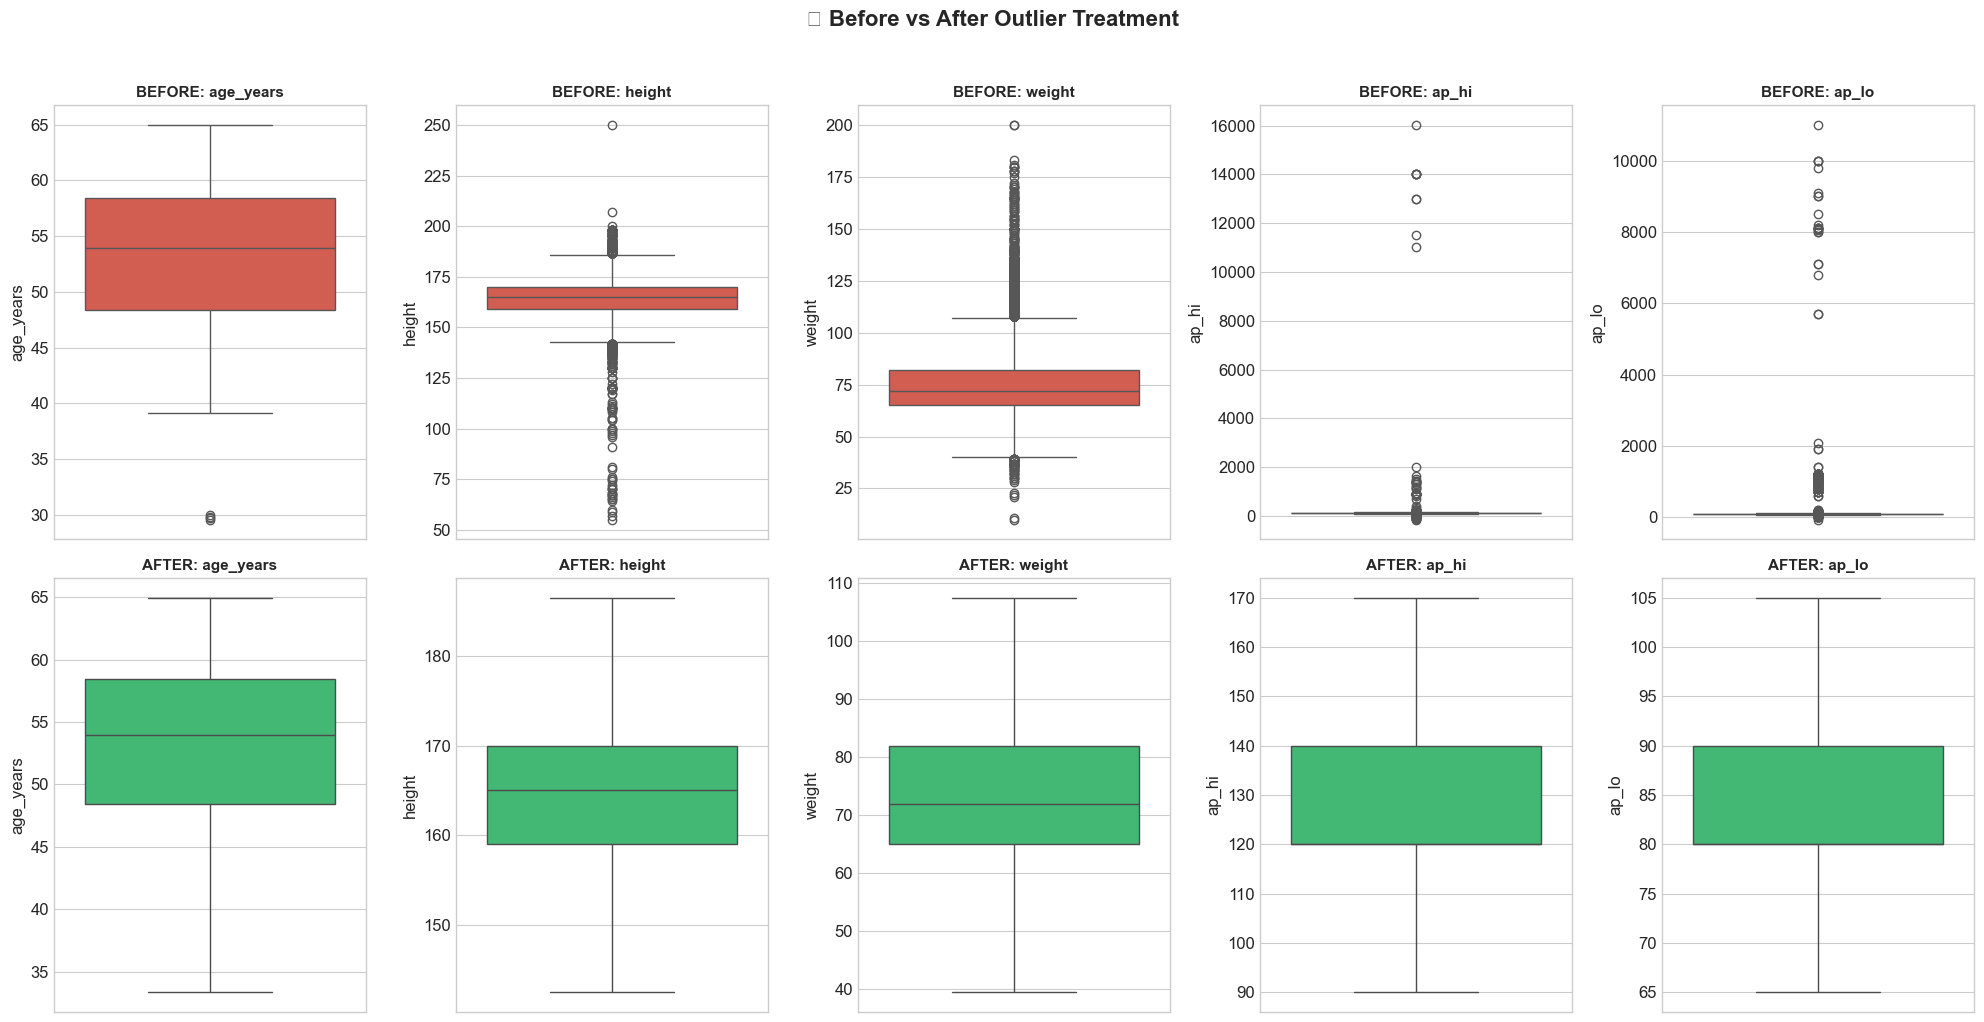

✅ Chart saved to ../results/08_before_after_boxplots.png


In [18]:
# Before vs After comparison - Box plots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col_name in enumerate(numeric_for_outliers):
    # Before
    sns.boxplot(y=pdf[col_name], ax=axes[0, idx], color='#e74c3c')
    axes[0, idx].set_title(f'BEFORE: {col_name}', fontsize=11, fontweight='bold')
    # After
    sns.boxplot(y=pdf_clean[col_name], ax=axes[1, idx], color='#2ecc71')
    axes[1, idx].set_title(f'AFTER: {col_name}', fontsize=11, fontweight='bold')

plt.suptitle('📦 Before vs After Outlier Treatment', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/08_before_after_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/08_before_after_boxplots.png')

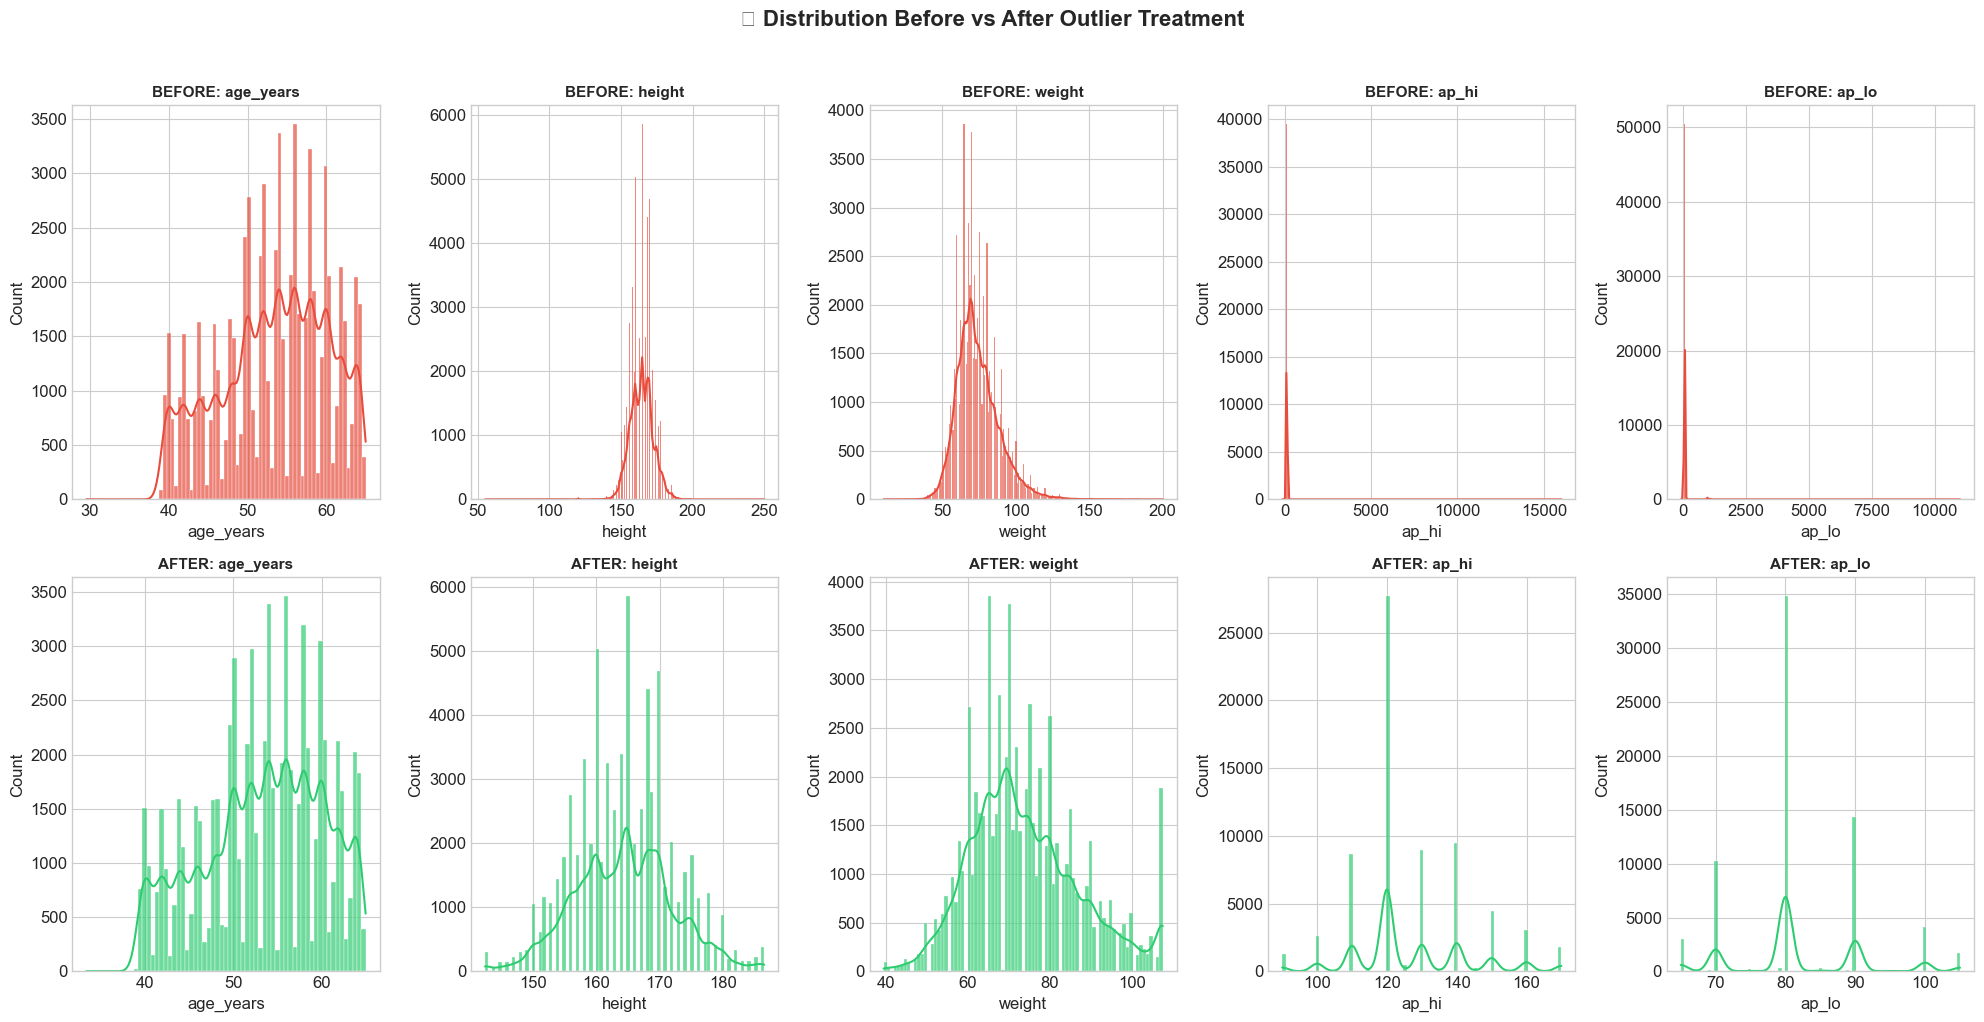

✅ Chart saved to ../results/09_before_after_histograms.png


In [19]:
# Before vs After comparison - Histograms
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for idx, col_name in enumerate(numeric_for_outliers):
    # Before
    sns.histplot(pdf[col_name], kde=True, ax=axes[0, idx], color='#e74c3c', alpha=0.7)
    axes[0, idx].set_title(f'BEFORE: {col_name}', fontsize=11, fontweight='bold')
    # After
    sns.histplot(pdf_clean[col_name], kde=True, ax=axes[1, idx], color='#2ecc71', alpha=0.7)
    axes[1, idx].set_title(f'AFTER: {col_name}', fontsize=11, fontweight='bold')

plt.suptitle('📊 Distribution Before vs After Outlier Treatment', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/09_before_after_histograms.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/09_before_after_histograms.png')

## 🔬 11. Violin Plots Analysis

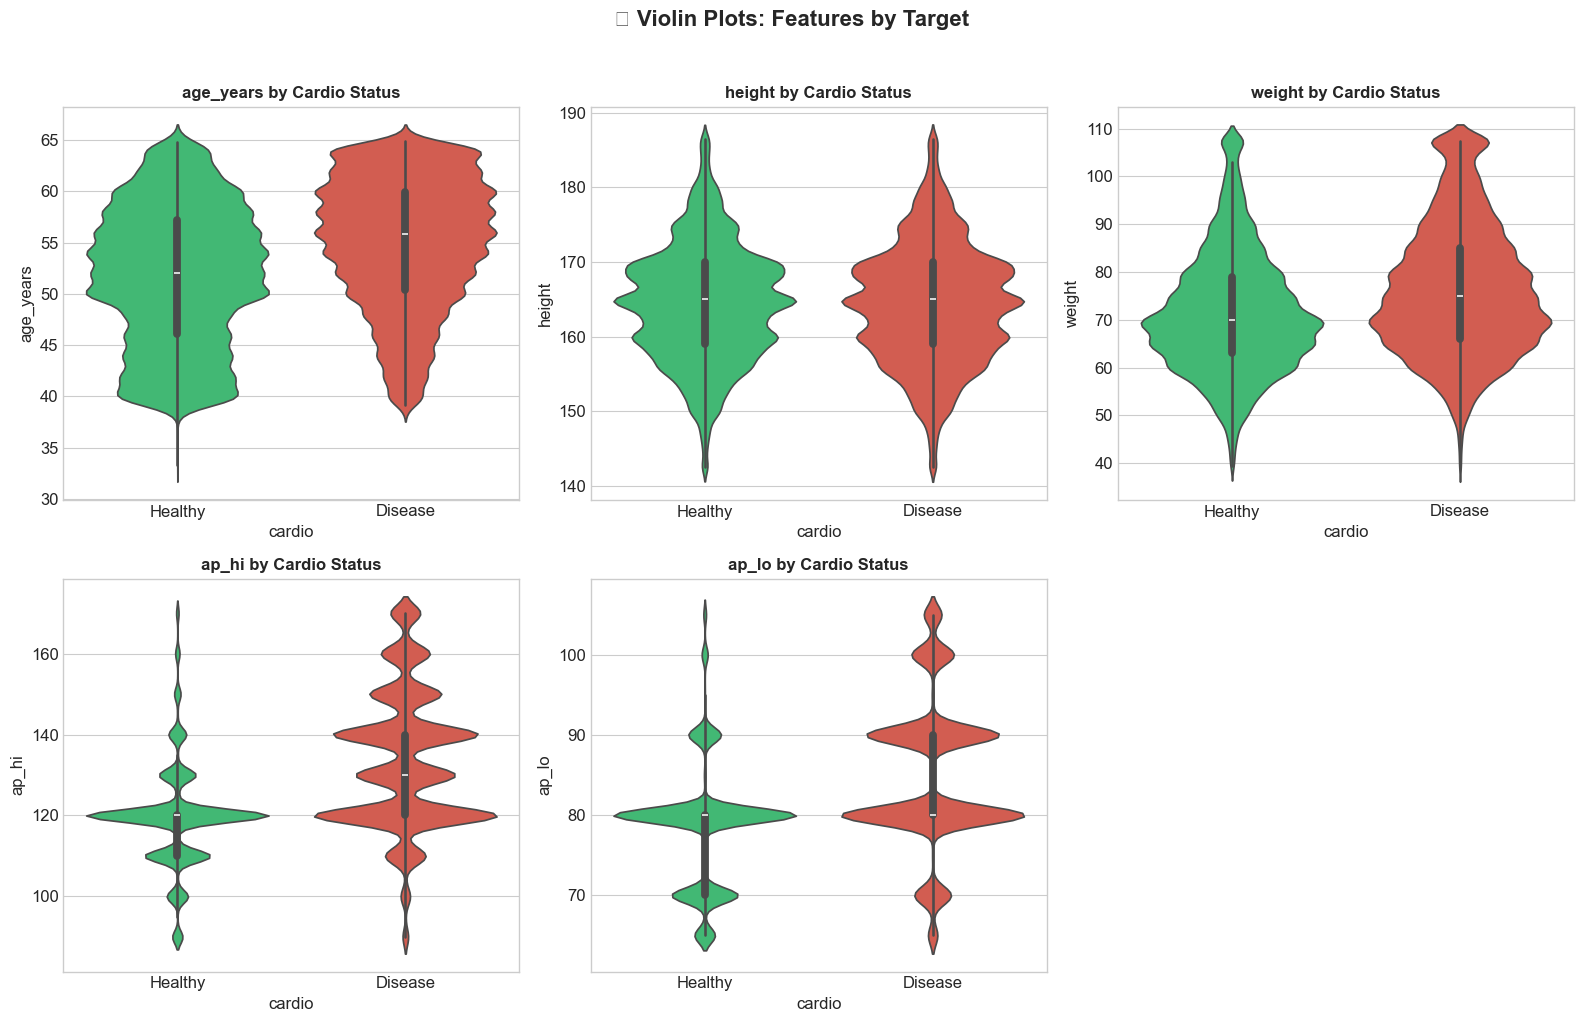

✅ Chart saved to ../results/10_violin_plots.png


In [20]:
# Violin plots by cardio status
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col_name in enumerate(numeric_for_outliers):
    sns.violinplot(x='cardio', y=col_name, data=pdf_clean, ax=axes[idx], palette=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{col_name} by Cardio Status', fontsize=12, fontweight='bold')
    axes[idx].set_xticklabels(['Healthy', 'Disease'])

axes[5].axis('off')
plt.suptitle('🎻 Violin Plots: Features by Target', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/10_violin_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/10_violin_plots.png')

## ⚙️ 12. Feature Engineering

In [21]:
# Add new features
print('⚙️ Creating new features...')

# BMI
pdf_clean['bmi'] = pdf_clean['weight'] / ((pdf_clean['height'] / 100) ** 2)
print('  ✅ BMI calculated')

# Pulse Pressure
pdf_clean['pulse_pressure'] = pdf_clean['ap_hi'] - pdf_clean['ap_lo']
print('  ✅ Pulse Pressure calculated')

# Blood Pressure Category
def bp_category(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 0  # Normal
    elif row['ap_hi'] < 130 and row['ap_lo'] < 80:
        return 1  # Elevated
    elif row['ap_hi'] < 140 or row['ap_lo'] < 90:
        return 2  # High Stage 1
    else:
        return 3  # High Stage 2

pdf_clean['bp_category'] = pdf_clean.apply(bp_category, axis=1)
print('  ✅ Blood Pressure Category created')

print('\n📊 New features added:')
print(pdf_clean[['bmi', 'pulse_pressure', 'bp_category']].describe())

⚙️ Creating new features...
  ✅ BMI calculated
  ✅ Pulse Pressure calculated
  ✅ Blood Pressure Category created

📊 New features added:
                bmi  pulse_pressure   bp_category
count  70000.000000    70000.000000  70000.000000
mean      27.388907       44.932829      1.896986
std        4.943769       11.623692      0.893988
min       12.466860      -15.000000      0.000000
25%       23.875115       40.000000      2.000000
50%       26.377898       40.000000      2.000000
75%       30.189591       50.000000      2.000000
max       52.939366      105.000000      3.000000


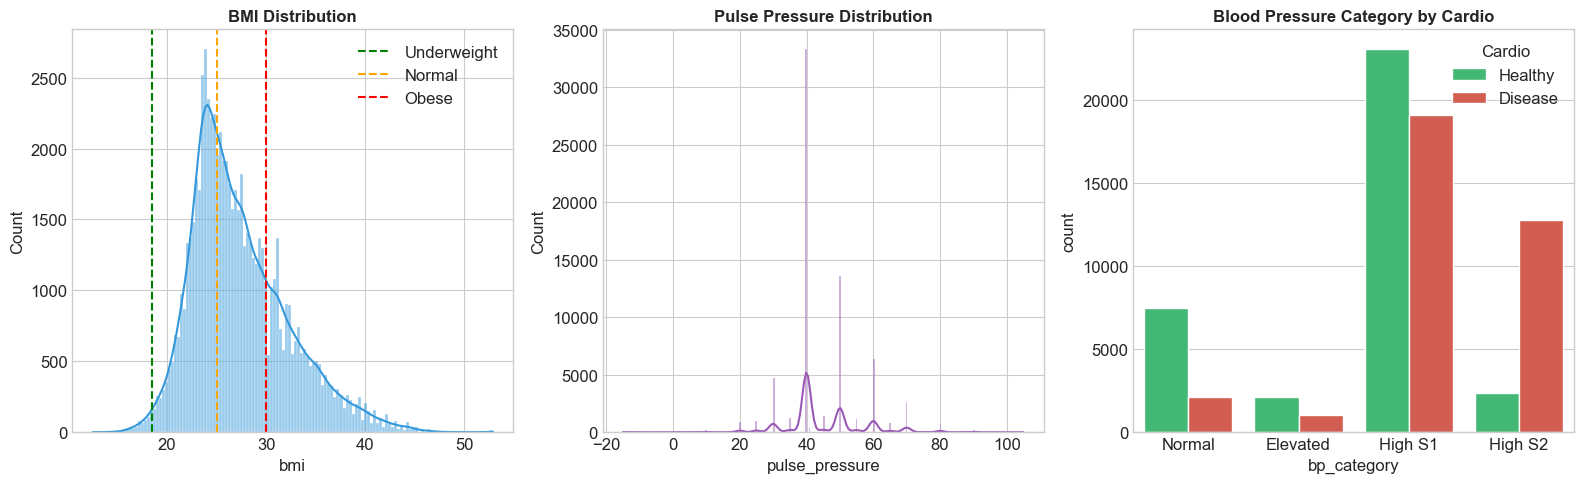

✅ Chart saved to ../results/11_new_features.png


In [22]:
# Visualize new features
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# BMI distribution
sns.histplot(pdf_clean['bmi'], kde=True, ax=axes[0], color='#3498db')
axes[0].axvline(18.5, color='green', linestyle='--', label='Underweight')
axes[0].axvline(25, color='orange', linestyle='--', label='Normal')
axes[0].axvline(30, color='red', linestyle='--', label='Obese')
axes[0].set_title('BMI Distribution', fontsize=12, fontweight='bold')
axes[0].legend()

# Pulse Pressure
sns.histplot(pdf_clean['pulse_pressure'], kde=True, ax=axes[1], color='#9b59b6')
axes[1].set_title('Pulse Pressure Distribution', fontsize=12, fontweight='bold')

# BP Category
sns.countplot(x='bp_category', hue='cardio', data=pdf_clean, ax=axes[2], palette=['#2ecc71', '#e74c3c'])
axes[2].set_title('Blood Pressure Category by Cardio', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(['Normal', 'Elevated', 'High S1', 'High S2'])
axes[2].legend(title='Cardio', labels=['Healthy', 'Disease'])

plt.tight_layout()
plt.savefig('../results/11_new_features.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved to ../results/11_new_features.png')

## 🔄 13. Final Preprocessing with Spark

In [2]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# ================================
# 1. Convert pandas -> Spark
# ================================
df_clean = spark.createDataFrame(pdf_clean)

# ================================
# 2. Feature columns
# ================================
feature_cols = [
    'age_years', 'gender', 'height', 'weight',
    'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
    'smoke', 'alco', 'active',
    'bmi', 'pulse_pressure', 'bp_category'
]

# ================================
# 3. Vector Assembler
# ================================
print('🔧 Assembling features...')
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)

df_assembled = assembler.transform(df_clean)

# ================================
# 4. Standard Scaler
# ================================
print('📏 Scaling features...')
scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=True
)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# ================================
# 5. Convert Vector → Array (QUAN TRỌNG)
# ================================
df_array = df_scaled.withColumn(
    "scaled_array",
    vector_to_array(col("scaled_features"))
)

# ================================
# 6. Expand array → columns (pretty output)
# ================================
df_pretty = df_array.select(
    "*",
    *[
        col("scaled_array")[i].alias(f"scaled_{feature_cols[i]}")
        for i in range(len(feature_cols))
    ]
)

# ================================
# 7. Final display (EDA-friendly)
# ================================
print("\n✅ Preprocessing completed! (Readable output)\n")

df_pretty.select(
    *[f"scaled_{c}" for c in feature_cols],
    "cardio"
).show(5, truncate=False)


NameError: name 'pdf_clean' is not defined

In [ ]:
# Save processed data
output_path = '../data/processed/cardio_processed.parquet'
df_scaled.write.mode('overwrite').parquet(output_path)
print(f'✅ Processed data saved to {output_path}')

# Also save feature columns for modeling
with open('../data/processed/feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print('✅ Feature columns saved')

## 📊 14. Final Summary

In [ ]:
# Summary statistics comparison
print('=' * 60)
print('📊 EDA & PREPROCESSING SUMMARY')
print('=' * 60)
print(f'\n📁 Original dataset: 70,000 rows')
print(f'📁 After cleaning: {df_scaled.count()} rows')
print(f'📁 Features used: {len(feature_cols)}')
print(f'\n📝 Feature list:')
for i, feat in enumerate(feature_cols, 1):
    print(f'  {i:2d}. {feat}')
print(f'\n🎯 Target: cardio (0: Healthy, 1: Heart Disease)')
print(f'\n💾 Output files:')
print(f'  • data/processed/cardio_processed.parquet')
print(f'  • data/processed/feature_columns.txt')
print(f'  • results/*.png (visualization charts)')
print('\n✅ Ready for modeling!')

In [ ]:
# Stop Spark session reminder
print('💡 Note: Run spark.stop() when done to release resources')

---
## 📌 Charts Generated

| # | Chart | File |
|---|-------|------|
| 1 | Target Distribution | 01_target_distribution.png |
| 2 | Numeric Distributions | 02_numeric_distributions.png |
| 3 | Categorical by Target | 03_categorical_by_target.png |
| 4 | Correlation Matrix | 04_correlation_matrix.png |
| 5 | Target Correlation | 05_target_correlation.png |
| 6 | Box Plots Before | 06_boxplots_before.png |
| 7 | Outlier Counts | 07_outlier_counts.png |
| 8 | Before/After Box Plots | 08_before_after_boxplots.png |
| 9 | Before/After Histograms | 09_before_after_histograms.png |
| 10 | Violin Plots | 10_violin_plots.png |
| 11 | New Features | 11_new_features.png |